# Ungraded Lab: Using more sophisticated images with Convolutional Neural Networks

In Course 1 of this Specialization, you saw how to use a Convolutional Neural Networks (CNNs)  to make recognition of computer generated images of horses and humans more efficient. In this lesson, you'll take that to the next level: building a model to classify real images of cats and dogs. Like the horses and humans dataset, real-world images also come in different shapes, aspect ratios, etc. and you will need to consider these when preparing your data.

In this lab, you will review how to build CNNs, preprocess the data with the `tf.data` API, and examine your results. You'll follow these steps:

1.   Explore the example data of `Dogs vs. Cats`
2.   Build and train a neural network to classify between the two pets
3.   Evaluate the training and validation accuracy

You will build upon your results here in the next labs so you can improve it, particularly in avoiding overfitting. Let's begin!

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Running it on your local machine might result in some of the code blocks throwing errors.

## Download and Inspect the Dataset

You will start by looking at the dataset. It consists of of 2,000 JPG pictures of cats and dogs. It is a subset of the "Dogs vs. Cats" dataset available on Kaggle, which contains 25,000 images. You will only use 2,000 of the full dataset to decrease training time for educational purposes.

You can uncomment the line of code below to download the dataset to your notebook.

In [ ]:
#!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

You can run the following code to mount Google Drive in your Google Colab environment. This will allow you to access and work with files stored in your Google Drive directly from your Colab notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Access the path where the image dataset is located, and unzip it.

In [ ]:
import os
import zipfile # extract files .zip

# View current directory
print(f"The current path is: {os.getcwd()}")

# Path with cat and dog pictures
path_cats_dogs_pic = '/content/drive/MyDrive/Tensorflow/DeepLearning.AI/C2/W1/Ungraded/Lab1'
os.chdir(path_cats_dogs_pic)
print(f"The new current path is: {path_cats_dogs_pic}")

# Unzip the files only if the Files folder exists and is a directory in the file system
zip_files = 'Files.zip'  # Name of the zip folder
unzip_files = 'Files/'   # Name of the unzip folder

if os.path.exists(unzip_files) and os.path.isdir(unzip_files):
  print(f"The folder '{unzip_files}' already exists and is a directory.")
else:
  print(f"The folder '{unzip_files}' does not exist or is not a directory.")
  zip_ref = zipfile.ZipFile(zip_files, 'r')
  zip_ref.extractall(unzip_files)
  zip_ref.close()

# View files
!ls

The current path is: /content
The new current path is: /content/drive/MyDrive/Tensorflow/DeepLearning.AI/C2/W1/Ungraded/Lab1
La carpeta 'Files/' ya existe y es un directorio.
C2_W1_Lab_1_cats_vs_dogs.ipynb	Files  Files.zip  history_augmented.pkl


The contents are already saved to the base directory `./cats_and_dogs_filtered`, which contains `train` and `validation` subdirectories for the training and validation datasets (you can ignore `vectorize.py` in the output in the next cell).

If you recall, the **training set** is the data that is used to tell the neural network model that 'this is what a cat looks like' and 'this is what a dog looks like'. The **validation set** is images of cats and dogs that the neural network will not see as part of the training. You can use this to test how well or how badly it does in evaluating if an image contains a cat or a dog. (See the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/validation/check-your-intuition) if you want a refresher on training, validation, and test sets.)

These subdirectories in turn each contain `cats` and `dogs` subdirectories. You can assign each of these directories to a variable so you can use it later.

In [ ]:
# Base Directory
BASE_DIR = os.path.join(os.getcwd(), 'Files/Files', 'cats_and_dogs_filtered')
print(f'Contents of base directory are: {os.listdir(BASE_DIR)}')

# Train and validation directory
train_dir = os.path.join(BASE_DIR, 'train')
validation_dir = os.path.join(BASE_DIR, 'validation')
print(f'Contents of training subdirectory are {os.listdir(train_dir)} and validation subdirectory are {os.listdir(validation_dir)}')

# Directory with training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
print(f'Visualization of four cat images {os.listdir(train_cats_dir)[:4]} and four dogs images {os.listdir(train_dogs_dir)[:4]} of the training dataset')

# Directory with validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print(f'Visualization of four cat images {os.listdir(train_cats_dir)[:4]} and four dogs images {os.listdir(train_dogs_dir)[:4]} of the validation dataset')

print(f'There are {len(os.listdir(train_cats_dir))} cat images and {len(os.listdir(train_dogs_dir))} dog images in the training dataset')
print(f'There are {len(os.listdir(validation_cats_dir))} cat images and {len(os.listdir(validation_dogs_dir))} dog images in the validation dataset')

Contents of base directory are: ['train', 'validation', 'vectorize.py']
Contents of training subdirectory are ['dogs', 'cats'] and validation subdirectory are ['dogs', 'cats']
Visualization of four cat images ['cat.227.jpg', 'cat.308.jpg', 'cat.146.jpg', 'cat.623.jpg'] and four dogs images ['dog.540.jpg', 'dog.702.jpg', 'dog.621.jpg', 'dog.90.jpg'] of the training dataset
Visualization of four cat images ['cat.227.jpg', 'cat.308.jpg', 'cat.146.jpg', 'cat.623.jpg'] and four dogs images ['dog.540.jpg', 'dog.702.jpg', 'dog.621.jpg', 'dog.90.jpg'] of the validation dataset
There are 1000 cat images and 1000 dog images in the training dataset
There are 500 cat images and 500 dog images in the validation dataset


For both cats and dogs, you have 1,000 training images and 500 validation images.

Now take a look at a few pictures to get a better sense of what the cat and dog datasets look like. You can re-run the cell to see a fresh batch each time:

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from math import ceil

nimgs = 8 # number of dog and cat images to be displayed

def show_images(img_paths, label):
    ncols = 4
    nrows = ceil(len(img_paths)/ncols) # The number of rows changes dynamically according to the number of images, keeping the number of columns at four

    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)

    for i, img_path in enumerate(img_paths):
        # Set up subplot; subplot indices start at 1
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('ON') # Show axes (or gridlines) to visualize the size of each image.

        img = mpimg.imread(img_path)
        plt.imshow(img)

    # Unique label for all cat and dog images respectively
    plt.subplot(1, 1, 1)
    plt.title(label, loc='center', fontsize=25, fontweight='bold')
    plt.axis('OFF')
    plt.show()

next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in random.sample(os.listdir(train_cats_dir), nimgs)]

next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in random.sample(os.listdir(train_dogs_dir), nimgs)]

# Show cat images with a label
show_images(next_cat_pix, 'CATS')

# Show dog images with a label
show_images(next_dog_pix, 'DOGS')

Output hidden; open in https://colab.research.google.com to view.

An important note here is that these images come in all shapes and sizes.

## Building a Small Model from Scratch

To train a neural network to handle the images, you'll need them to be in a uniform size. You will choose 150x150 pixels for this, and you'll see the code that preprocesses the images to that shape shortly.

You can define the model by importing Tensorflow and using the Keras API. Here is the entire code first then the discussion comes after. This is very similar to the models you built in Course 1.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Rescaling, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop

class CatDogClassifier:
    def __init__(self):
        self.model = self.create_model()

    def create_model(self):
        return Sequential([
            # Rescale the image. Note the input shape is the desired size of the image: 150x150 with 3 bytes for color
            Input(shape=(150, 150, 3)),
            Rescaling(1./255),
            # Convolution and Pooling layers
            Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
            MaxPooling2D(2, 2),
            Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
            MaxPooling2D(2, 2),
            Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
            MaxPooling2D(2, 2),
            # Flatten the results to feed into a DNN
            Flatten(),
            # 512 neuron hidden layer
            Dense(units= 512, activation='relu'),
            # Only 1 output neuron. It will contain a value from 0-1 where 0 for one class ('cats') and 1 for the other ('dogs')
            Dense(units= 1, activation='sigmoid')
        ])

    def compile_model(self):
        self.model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    def summary(self):
        self.model.summary()

    def fit(self, train_data, epochs=15, validation_data=None, verbose=None):
        return self.model.fit(x=train_dataset, epochs=epochs, validation_data=validation_data, verbose=verbose)

# Create an instance of the CatDogClassifier class.
classifier = CatDogClassifier()

# Compile the model
classifier.compile_model()

# Show the model summary
classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18496)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       9,470,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,494,561 (36.22 MB)

 Trainable params: 9,494,561 (36.22 MB)

 Non-trainable params: 0 (0.00 B)

You defined a Sequential model as before. The first layer is the Rescaling layer. Note the input_shape parameter. Here is where you put the 150x150 size and 3 for the color depth because you have colored images.

Images that go into neural networks are usually normalized to make them more amenable to processing by the network. In this case, your model will rescale the pixel values from being in the [0, 255] range into the [0, 1] range. Next, you added some convolutional and pooling layers to extract features. Then, you will flatten the result to feed into the densely connected layers.

Because you are facing a two-class classification problem, i.e. a binary classification problem, you will end the network with a sigmoid activation. The output will be a single scalar between 0 (Cat) and 1 (Dog), encoding the probability that the current image is class 1 (as opposed to class 0).

You can review the architecture of the network with the model.summary() method. The `output_shape` column shows how the size of your feature map evolves in each successive layer. The convolution operation removes the outermost pixels from the original dimensions, and each pooling layer halves it.

You will train our model with the binary_crossentropy loss, because it's a binary classification problem and your final activation is a sigmoid. We will use the rmsprop optimizer with a learning rate of 0.001. During training, you will want to monitor classification accuracy.

**NOTE:** In this case, using the RMSprop optimization algorithm is preferable to stochastic gradient descent (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as Adam and Adagrad, also automatically adapt the learning rate during training, and would work equally well here.)

### Data Preprocessing

Next step is to set up the `tf.data.Dataset` objects that will read pictures in the source folders and feed them (with their labels) to the model. You'll have one for the training images and another for the validation images. These will yield batches of images of size 150x150 and their labels (binary).

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

def create_dataset(directory, image_size, batch_size=None, label_mode=None):
  return image_dataset_from_directory(directory=directory, image_size=image_size, batch_size=batch_size, label_mode=label_mode)

# Instantiate the Dataset object for the training set
train_dataset = create_dataset(train_dir, (150,150), 20, 'binary')

# Instantiate the Dataset object for the validation set
validation_dataset = create_dataset(validation_dir, (150,150), 20, 'binary')

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


You will then chain a few more methods to optimize the datasets for training and validation. As a refresher:
* [cache()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) stores elements in memory as you use them so it will be faster to retrieve if you need them again
* [shuffle()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle), as the name suggests, shuffles the dataset randomly. A `buffer_size` of 1000 means it will first select a sample from the first 1,000 elements, then keep filling this buffer until all elements have been selected.
* [prefetch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) gets elements while the model is training so it's faster to feed in new data when the current training step is finished. A `buffer_size` set to `tf.data.AUTOTUNE` dynamically sets the number of elements to prefetch during runtime.

In [ ]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = train_dataset.cache().shuffle(SHUFFLE_BUFFER_SIZE).prefetch(PREFETCH_BUFFER_SIZE)
validation_dataset_final = validation_dataset.cache().prefetch(PREFETCH_BUFFER_SIZE)

### Training
You will now train on all 2,000 images available, for 15 epochs, and monitor the accuracy as well on the 1,000 images in the validation set.

Do note the values per epoch. You'll see 4 -- Loss, Accuracy, Validation Loss and Validation Accuracy.

The `loss` and `accuracy` are great indicators of progress in training. `loss` measures the current model prediction against the known labels, calculating the result. `accuracy`, on the other hand, is the portion of correct guesses.

In [ ]:
history = classifier.fit(train_data=train_dataset_final, epochs=15, validation_data=validation_dataset_final, verbose=1)

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 480s 5s/step - accuracy: 0.5259 - loss: 0.7098 - val_accuracy: 0.6020 - val_loss: 0.6460
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 65ms/step - accuracy: 0.6283 - loss: 0.6483 - val_accuracy: 0.6790 - val_loss: 0.6083
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.6985 - loss: 0.6047 - val_accuracy: 0.7020 - val_loss: 0.5803
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7342 - loss: 0.5167 - val_accuracy: 0.6750 - val_loss: 0.6413
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.7858 - loss: 0.4639 - val_accuracy: 0.6870 - val_loss: 0.6057
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.8301 - loss: 0.3898 - val_accuracy: 0.7170 - val_loss: 0.6002
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.8629 - loss: 0.3184 - val_accuracy: 0.7320 - val_loss: 0.5816
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9038 - loss: 0.2443 - val_a

### Model Prediction

Now take a look at actually running a prediction using the model. This code will allow you to choose 1 or more files from your file system, upload them, and run them through the model, giving an indication of whether the object is a cat or a dog.

In [ ]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

path_name = '/content/drive/MyDrive/Tensorflow/DeepLearning.AI/C2/W1/Ungraded/Lab1/'

def predict_images_dog_cat(path_name, model):
    uploaded = files.upload()

    for file_name in uploaded.keys():
        # Predicting images
        path = path_name + file_name
        img = image.load_img(path, target_size=(150, 150))
        img = image.img_to_array(img)
        img /= 255
        img = np.expand_dims(img, axis=0)
        images = np.vstack([img])

        classes = model.predict(images, batch_size=10)

        print(f'The prediction is {classes[0][0]}')
        print(f"{file_name} is a {'dog' if classes[0] > 0.5 else 'cat'}")

predict_images_dog_cat(path_name, classifier.model)

Saving dog_1.jpeg to dog_1.jpeg
Saving dog_2.jpeg to dog_2.jpeg
Saving dog_3.jpeg to dog_3.jpeg
Saving cat_3.jpeg to cat_3.jpeg
Saving cat_2.jpeg to cat_2.jpeg
Saving cat_1.jpeg to cat_1.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
The prediction is 5.4887823353055865e-06
dog_1.jpeg is a cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
The prediction is 5.445434453577036e-06
dog_2.jpeg is a cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
The prediction is 5.546061402128544e-06
dog_3.jpeg is a cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
The prediction is 5.7191759879060555e-06
cat_3.jpeg is a cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
The prediction is 5.75701142224716e-06
cat_2.jpeg is a cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
The prediction is 5.7191759879060555e-06
cat_1.jpeg is a cat


### Visualizing Intermediate Representations

To get a feel for what kind of features your CNN has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the model.

You can pick a random image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


<ipython-input-11-fd7eebb4f0ab>:41: RuntimeWarning: invalid value encountered in divide
  x /= x.std ()
<ipython-input-11-fd7eebb4f0ab>:44: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


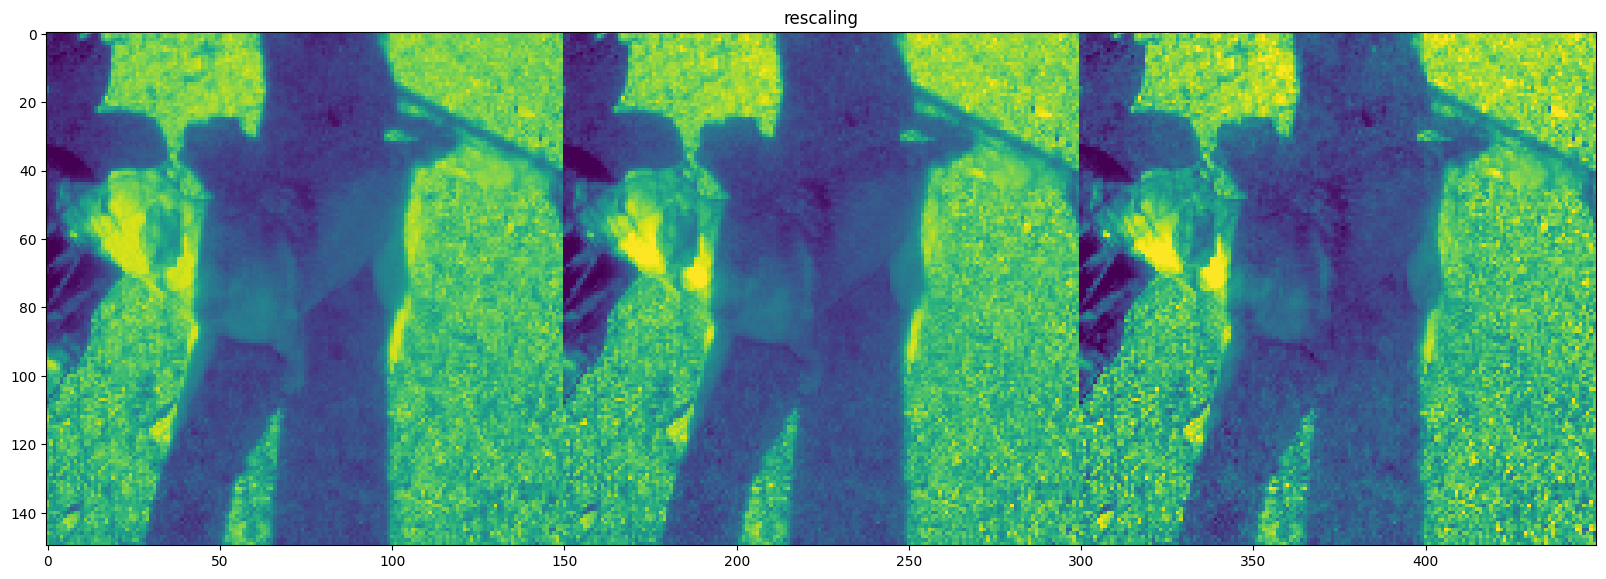

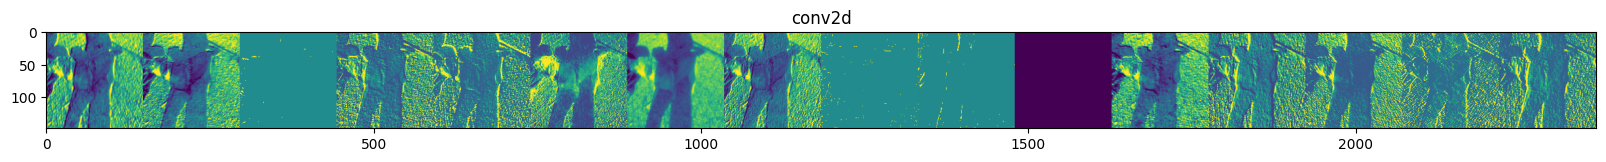

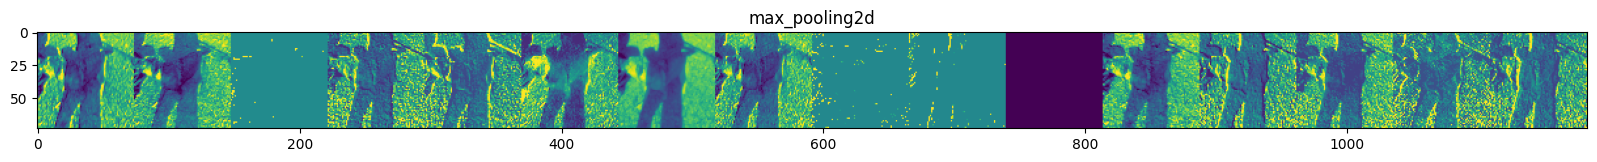

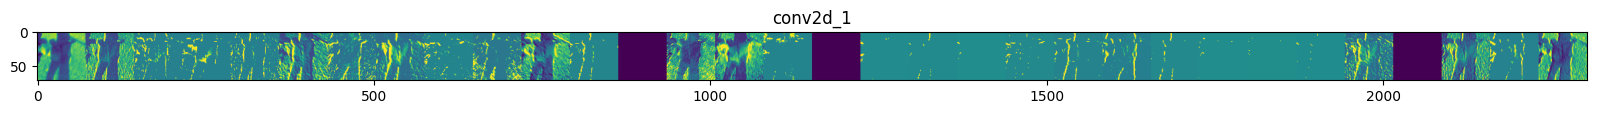

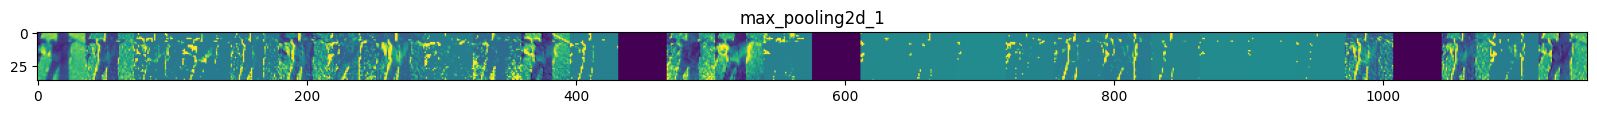

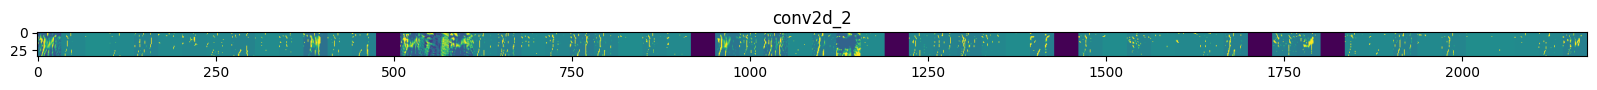

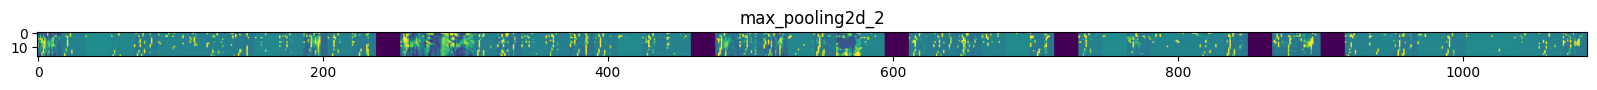

In [ ]:
# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model
successive_outputs = [layer.output for layer in classifier.model.layers]
visualization_model = tf.keras.models.Model(inputs = classifier.model.inputs, outputs = successive_outputs)

# Prepare a random input image from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in os.listdir(train_cats_dir)]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in os.listdir(train_dogs_dir)]
img_path = random.choice(cat_img_files + dog_img_files)
img = tf.keras.utils.load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = tf.keras.utils.img_to_array(img) # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape) # Numpy array with shape (1, 150, 150, 3)

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of our plot
layer_names = [layer.name for layer in classifier.model.layers]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):

    if len(feature_map.shape) == 4:

        #-------------------------------------------
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        #-------------------------------------------
        n_features = feature_map.shape[-1]  # number of features in the feature map
        size = feature_map.shape[1]  # feature map shape (1, size, size, n_features)

        # Tile the images in this matrix
        display_grid = np.zeros((size, size * n_features))

        #-------------------------------------------------
        # Postprocess the feature to be visually palatable
        #-------------------------------------------------
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std ()
            x *=  64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

        #-----------------
        # Display the grid
        #-----------------
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

You can see above how the pixels highlighted turn to increasingly abstract and compact representations, especially at the bottom grid.

The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called _representation sparsity_ and is a key feature of deep learning. These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a CNN (or a deep network in general) as an information distillation pipeline wherein each layer filters out the most useful features.

### Evaluating Accuracy and Loss for the Model

You will plot the training/validation accuracy and loss as collected during training:

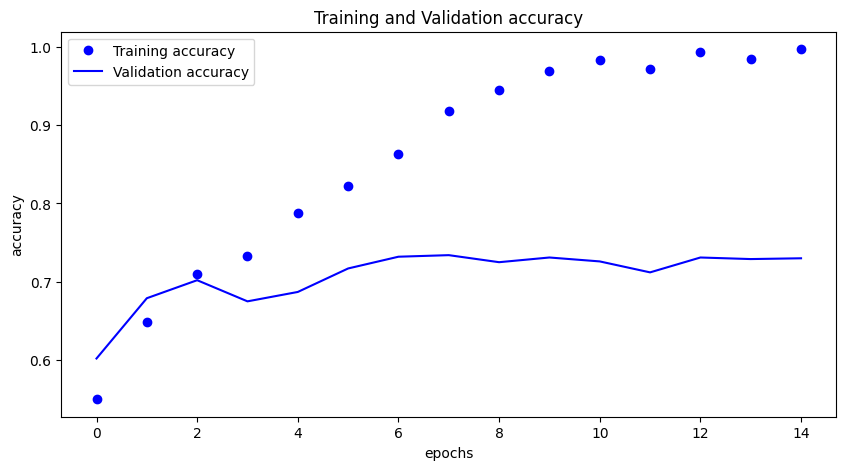

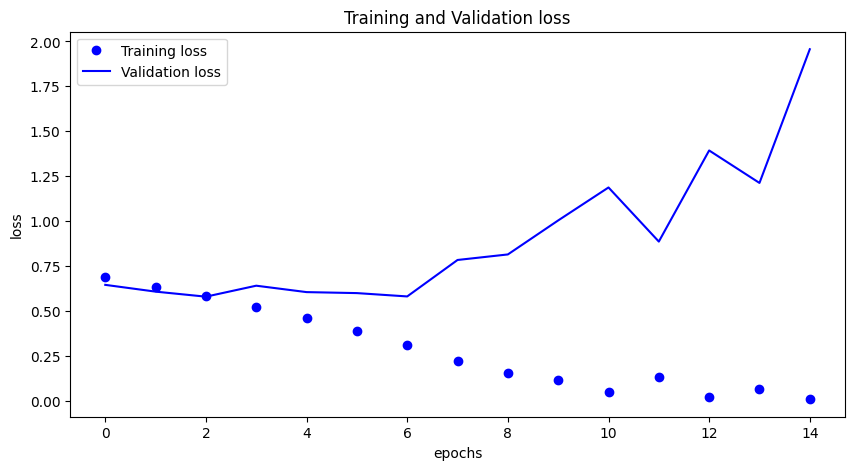

In [ ]:
import matplotlib.pyplot as plt

def plot_metric(history, metric_name):
    '''Plots the training and validation loss and accuracy from a history object'''
    plt.figure(figsize=(10, 5))

    graph_1 = history.history[metric_name]
    graph_2 = history.history['val_' + metric_name]
    # range(len(graph_1)) == range(len(graph_2)) == each_epochs
    plt.plot(range(len(graph_1)), graph_1, 'bo', label='Training' + ' ' +  metric_name)
    plt.plot(range(len(graph_2)), graph_2, 'b', label='Validation' + ' ' +  metric_name)
    plt.title('Training and Validation' + ' ' + metric_name)
    plt.xlabel('epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

plot_metric(history, 'accuracy')
plot_metric(history, 'loss')

As you can see, the model is **overfitting** like it's getting out of fashion. The training accuracy (in blue) gets close to 100% while the validation accuracy (solid line) stalls at 70%. The validation loss reaches its minimum after only five epochs.

Since you have a relatively small number of training examples (2000), overfitting should be the number one concern. Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data, i.e. when the model starts using irrelevant features for making predictions. For instance, if you, as a human, only see three images of people who are lumberjacks, and three images of people who are sailors, and among them the only person wearing a cap is a lumberjack, you might start thinking that wearing a cap is a sign of being a lumberjack as opposed to a sailor. You would then make a pretty lousy lumberjack/sailor classifier.

Overfitting is the central problem in machine learning: given that you are fitting the parameters of our model to a given dataset, how can you make sure that the representations learned by the model will be applicable to data it has never seen before? How do you avoid learning things that are specific to the training data?

In the next exercise, you'll look at ways to prevent overfitting in this classification model.

### Save the history

In [ ]:
import pickle
from google.colab import files

def download_history():
  with open('history_augmented.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history_augmented.pkl')

download_history()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Clean Up

Before running the next exercise, run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal

os.kill(os.getpid(), signal.SIGKILL)